Step 0:
  Filtered Pose:       [ 0.06787845 -0.08238131 -0.10611624  0.1600166   0.64520673 -0.47033057]
  Filtered Velocity:   [ 0.00061702 -0.00074885 -0.00096461]
  Filtered Angular Velocity:   [ 0.00617152  0.01213222 -0.01025814]
Step 1:
  Filtered Pose:       [ 0.09792994 -0.06744883 -0.30040418 -0.07900004  0.60833379 -0.49229171]
  Filtered Velocity:   [ 0.00155369 -0.0002831  -0.00702127]
  Filtered Angular Velocity:   [-0.00788892  0.01295003 -0.00691117]
Step 2:
  Filtered Pose:       [ 0.23167287 -0.18457653 -0.1907556   0.02835306  0.6511406   0.03413162]
  Filtered Velocity:   [ 0.01055704 -0.00816867  0.00036568]
  Filtered Angular Velocity:   [-0.01433057  0.01327759  0.04492553]
Step 3:
  Filtered Pose:       [ 0.19812605 -0.26262734 -0.18689178  0.09833082  0.55939875 -0.19155785]
  Filtered Velocity:   [ 0.00663456 -0.01725665  0.00081561]
  Filtered Angular Velocity:   [ 0.00621438 -0.0050393   0.00788419]
Step 4:
  Filtered Pose:       [ 0.264014   -0.20005027 -0.3

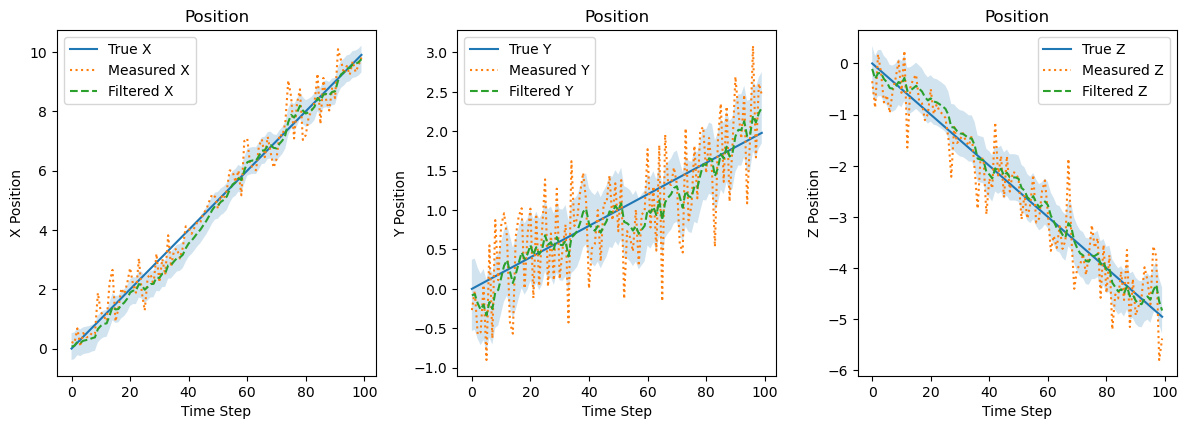

In [9]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

class PoseVelocityKalmanFilter:
    def __init__(self, initial_state, initial_covariance, process_noise, measurement_noise, dt):
        self.state = np.array(initial_state).reshape(13, 1)
        self.covariance = np.array(initial_covariance)
        self.process_noise = np.array(process_noise)
        self.measurement_noise = np.array(measurement_noise)
        self.dt = dt

        # State Transition Matrix (F) - Constant Acceleration Model (within each time step)
        self.F = np.eye(13)
        self.F[:3, 3:6] = np.eye(3) * self.dt  # x' = x + vx*dt, etc.
        # Simplified quaternion update (First order approximation)
        
        q = self.state[6:10]

        self.F[6:10, 10:] = 0.5 * dt * np.array([
                [-q[1,0], -q[2,0], -q[3,0]],
                [ q[0,0], -q[3,0],  q[2,0]],
                [ q[3,0],  q[0,0], -q[1,0]],
                [-q[2,0],  q[1,0],  q[0,0]]
            ])


        # Measurement Model (H) - Direct observation of position and quaternion
        self.H = np.zeros((7, 13))
        self.H[:3, :3] = np.eye(3)
        self.H[3:7, 6:10] = np.eye(4)


    def predict(self):
        """Predicts the next state."""

        #predict quaternion based on the angular velocity
        q = self.state[6:10]
        w = self.state[10:]

        q_delta =  0.5 * self.dt *  np.array([
            [-q[1,0], -q[2,0], -q[3,0]],
            [ q[0,0], -q[3,0],  q[2,0]],
            [ q[3,0],  q[0,0], -q[1,0]],
            [-q[2,0],  q[1,0],  q[0,0]]
        ]) @ w

        self.state[6:10] = q + q_delta
        self.state = self.F @ self.state
        self.covariance = self.F @ self.covariance @ self.F.T + self.process_noise
        self.state[6:10] = self.state[6:10] / np.linalg.norm(self.state[6:10]) #normalize quaternion


    def update(self, measurement):
        """Updates the state based on the measurement."""

        # Convert Euler angles to quaternion
        r = R.from_euler('xyz', measurement[3:], degrees=False)
        measurement_quaternion = r.as_quat()  # [x, y, z, w]
        measurement_quaternion = np.array([measurement_quaternion[3], measurement_quaternion[0], measurement_quaternion[1], measurement_quaternion[2]]) #reorder to [w,x,y,z]
        # Construct measurement vector (z)
        z = np.concatenate([measurement[:3], measurement_quaternion]).reshape(7, 1)

        # Innovation (y)
        y = z - self.H @ self.state

        # Innovation Covariance (S)
        S = self.H @ self.covariance @ self.H.T + self.measurement_noise

        # Kalman Gain (K)
        K = self.covariance @ self.H.T @ np.linalg.inv(S)

        # Update State
        self.state = self.state + K @ y

        # Update Covariance
        self.covariance = (np.eye(13) - K @ self.H) @ self.covariance
        self.state[6:10] = self.state[6:10] / np.linalg.norm(self.state[6:10]) #normalize quaternion



    def get_state(self):
        """Returns the current state estimate [x, y, z, vx, vy, vz, qw, qx, qy, qz, wx, wy, wz]."""
        return self.state.flatten()

    def get_pose(self):
        """Returns the current pose estimate [x, y, z, rx, ry, rz] (Euler angles)."""
        x, y, z, vx, vy, vz, qw, qx, qy, qz, wx, wy, wz = self.state.flatten()
        r = R.from_quat([qx, qy, qz, qw])  # Note the order for scipy.spatial.transform
        rx, ry, rz = r.as_euler('xyz', degrees=False)
        return np.array([x, y, z, rx, ry, rz])

    def get_velocity(self):
        """Returns the current velocity estimate [vx, vy, vz]."""
        return self.state[3:6].flatten()

    def get_angular_velocity(self):
        """Returns the current angular velocity estimate [wx, wy, wz]"""
        return self.state[10:].flatten()
    
# --- Example Usage ---
if __name__ == '__main__':
    # 1. Initialization
    dt = 0.01  # Time step

    # Initial state (example: starting at origin, no rotation, no velocity)
    initial_state = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]  # x, y, z, vx, vy, vz, qw, qx, qy, qz, wx, wy, wz

    # Initial covariance
    initial_covariance = np.diag([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1])

    # Process noise (tune these values)
    process_noise = np.diag([0.1**2, 0.01, 0.01, 0.1, 0.1, 0.1, 0.001, 0.001, 0.001, 0.001, 0.01, 0.01, 0.01])

    # Measurement noise (tune these values)
    measurement_noise = np.diag([0.5**2, 0.5**2, 0.5**2, 0.01, 0.01, 0.01, 0.01])


    # Create Kalman Filter instance
    kf = PoseVelocityKalmanFilter(initial_state, initial_covariance, process_noise, measurement_noise, dt)

    # --- Simulation Loop (replace with your actual sensor data) ---
    num_steps = 100
    previous_pose = np.array([0,0,0,0,0,0])
    
    # Store results for plotting
    true_poses = []
    measured_poses = []
    filtered_poses = []

    for i in range(num_steps):
        # Simulate a noisy measurement (replace with your sensor data)
        true_x = i * 0.1  # Example: moving along x-axis with constant velocity
        true_y = i * 0.02
        true_z = i * -0.05
        true_rx = 0.0
        true_ry = 0.0
        true_rz = i * 0.05  # Example: rotating around z-axis

        noise = np.random.normal(0, 0.5, 6)  # Add some noise
        measurement = np.array([true_x, true_y, true_z, true_rx, true_ry, true_rz]) + noise

        # Calculate velocity (using finite differences - simple example)
        # In a real application, you'd calculate this *before* the Kalman Filter update
        # using raw sensor data, and perhaps with some smoothing.

        current_pose = measurement
        velocity = (current_pose[:3] - previous_pose[:3]) / dt

        current_q = R.from_euler('xyz', current_pose[3:], degrees=False).as_quat()
        previous_q = R.from_euler('xyz', previous_pose[3:], degrees=False).as_quat()

        q_diff = R.from_quat(current_q) * R.from_quat(previous_q).inv()
        angular_velocity = q_diff.as_rotvec()/dt

        previous_pose = current_pose


        # Predict and Update
        kf.predict()
        kf.update(measurement)

        # Get the filtered state
        filtered_state = kf.get_state()
        filtered_pose = kf.get_pose()
        filtered_velocity = kf.get_velocity()
        filter_angular_velocity = kf.get_angular_velocity()

        # Store results
        true_poses.append([true_x, true_y, true_z, true_rx, true_ry, true_rz])
        measured_poses.append(measurement)
        filtered_poses.append(filtered_pose)

        print(f"Step {i}:")
        print(f"  Filtered Pose:       {filtered_pose}")
        print(f"  Filtered Velocity:   {filtered_velocity}")
        print(f"  Filtered Angular Velocity:   {filter_angular_velocity}")
        #print(f"  Calculated Velocity: {velocity}") # Compare with calculated velocity
        #print(f"  Calculate Angular Velocity: {angular_velocity}")

    # Convert to numpy arrays for easier plotting
    true_poses = np.array(true_poses)
    measured_poses = np.array(measured_poses)
    filtered_poses = np.array(filtered_poses)

    # Plot results
    plt.figure(figsize=(12, 8))

    # plot 95% confidence interval
    x = np.arange(0, num_steps)
    


    # Plot position
    plt.subplot(2, 3, 1)
    plt.plot(true_poses[:, 0], label='True X')
    plt.plot(measured_poses[:, 0], label='Measured X', linestyle='dotted')
    plt.plot(filtered_poses[:, 0], label='Filtered X', linestyle='dashed')
    plt.fill_between(x, filtered_poses[:, 0] - 2*np.sqrt(kf.covariance[0, 0]), filtered_poses[:, 0] + 2*np.sqrt(kf.covariance[0, 0]), alpha=0.2)
    plt.xlabel('Time Step')
    plt.ylabel('X Position')
    plt.legend()
    plt.title('Position')


    plt.subplot(2, 3, 2)
    plt.plot(true_poses[:, 1], label='True Y')
    plt.plot(measured_poses[:, 1], label='Measured Y', linestyle='dotted')
    plt.plot(filtered_poses[:, 1], label='Filtered Y', linestyle='dashed')
    plt.fill_between(x, filtered_poses[:, 1] - 2*np.sqrt(kf.covariance[1, 1]), filtered_poses[:, 1] + 2*np.sqrt(kf.covariance[1, 1]), alpha=0.2)
    plt.xlabel('Time Step')
    plt.ylabel('Y Position')
    plt.legend()
    plt.title('Position')

    plt.subplot(2, 3, 3)
    plt.plot(true_poses[:, 2], label='True Z')
    plt.plot(measured_poses[:, 2], label='Measured Z', linestyle='dotted')
    plt.plot(filtered_poses[:, 2], label='Filtered Z', linestyle='dashed')
    plt.fill_between(x, filtered_poses[:, 2] - 2*np.sqrt(kf.covariance[2, 2]), filtered_poses[:, 2] + 2*np.sqrt(kf.covariance[2, 2]), alpha=0.2)
    plt.xlabel('Time Step')
    plt.ylabel('Z Position')
    plt.legend()
    plt.title('Position')

    # Plot orientation (Euler angles)
    # plt.subplot(2, 1, 2)
    # plt.plot(true_poses[:, 5], label='True Rz')
    # plt.plot(measured_poses[:, 5], label='Measured Rz', linestyle='dotted')
    # plt.plot(filtered_poses[:, 5], label='Filtered Rz', linestyle='dashed')
    # plt.xlabel('Time Step')
    # plt.ylabel('Rz (Rotation around Z)')
    # plt.legend()
    # plt.title('Orientation')

    plt.tight_layout()
    plt.show()